# Final Project

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [133]:
paths = list(Path("Smart Building").rglob("*.*"))

co2_paths = [path for path in paths if path.name == 'co2.csv']
humidity_paths = [path for path in paths if path.name == 'humidity.csv']
temperature_paths = [path for path in paths if path.name == 'temperature.csv']
light_paths = [path for path in paths if path.name == 'light.csv']
pir_paths = [path for path in paths if path.name == 'pir.csv']

In [134]:
dataset = []
for light_path, temperature_path, co2_path, pir_path, humidity_path in zip(light_paths, temperature_paths, co2_paths, pir_paths, humidity_paths):
    light_df = pd.read_csv(light_path, names=['unix_time', 'light'], index_col='unix_time')
    temperature_df = pd.read_csv(temperature_path, names=['unix_time', 'temperature'], index_col='unix_time')
    co2_df = pd.read_csv(co2_path, names=['unix_time', 'co2'], index_col='unix_time')
    humidity_df = pd.read_csv(humidity_path, names=['unix_time', 'humidity'], index_col='unix_time')
    pir_df = pd.read_csv(pir_path, names=['unix_time', 'pir'], index_col='unix_time')
    
    df = pd.concat([light_df, temperature_df, co2_df, pir_df, humidity_df], axis=1, join="inner")
    df['room'] = light_path.parent.name
    dataset.append(df)
data = pd.concat(dataset)

data.head()

,light,temperature,co2,pir,humidity,room
unix_time,,,,,,
1377299108,97.0,23.94,495.0,0.0,45.34,413
1377457084,103.0,23.48,459.0,0.0,52.75,413
1377457963,104.0,23.50,456.0,0.0,52.71,413
1377462175,105.0,23.54,446.0,0.0,52.43,413
1377464765,111.0,23.56,463.0,0.0,52.30,413


In [135]:
print("Percentage of data missing")
data.isnull().sum().sort_values(ascending = False)/len(data)*100

Percentage of data missing


light          0.0
temperature    0.0
co2            0.0
pir            0.0
humidity       0.0
room           0.0
dtype: float64

In [136]:
data = data.dropna()
data.head(10)

,light,temperature,co2,pir,humidity,room
unix_time,,,,,,
1377299108,97.0,23.94,495.0,0.0,45.34,413
1377457084,103.0,23.48,459.0,0.0,52.75,413
1377457963,104.0,23.50,456.0,0.0,52.71,413
1377462175,105.0,23.54,446.0,0.0,52.43,413
1377464765,111.0,23.56,463.0,0.0,52.30,413
1377467333,159.0,23.65,458.0,0.0,52.21,413
1377470795,162.0,23.93,473.0,0.0,51.76,413
1377475133,182.0,24.36,455.0,0.0,50.83,413
1377478615,225.0,24.75,456.0,0.0,49.87,413


In [137]:
data.shape

(135386, 6)

In [138]:
data["pir"] = data["pir"].apply(lambda x: 0 if x == 0 else 1)

data["pir"].describe()

count    135386.000000
mean          0.067193
std           0.250357
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: pir, dtype: float64

In [139]:
from collections import Counter

def detectOutliers(data, n, features):
    outlier_rows = []
    for col in features:
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        IQR = Q3 - Q1
        outlierStep = IQR * 1.5
        outlierList = data[(data[col] < Q1 - outlierStep ) | (data[col] > Q3 + outlierStep)].index
        outlier_rows.extend(outlierList)
    # Counts the frequency of occurrences of each row index
    outlier_rows = Counter(outlier_rows)
    multiple_outliers = list(key for key, value in outlier_rows.items() if value > n)
    return multiple_outliers

outliers_to_drop = detectOutliers(data, 5, ["temperature", "light", "humidity", "co2"])
print("these rows will be dropped due to their outlier values: {} ".format(outliers_to_drop))

these rows will be dropped due to their outlier values: [1377565933, 1377566749, 1377569232, 1377570100, 1377570980, 1377571831, 1377825332, 1377826051, 1377826790, 1377828271, 1377829722, 1377907298, 1377908778, 1377911741, 1377912482, 1377914707, 1377468186, 1377476867, 1377549110, 1377792765, 1377792784, 1377793026, 1377819493, 1377882264, 1377894165, 1377938996, 1377941956, 1377565101, 1377446023, 1377457084, 1377457963, 1377466494, 1377467333, 1377470795, 1377472562, 1377474292, 1377475133, 1377478615, 1377481225, 1377517891, 1377598134, 1377602415, 1377603263, 1377605765, 1377940477, 1377942706, 1377944234, 1377944985, 1377946426, 1377947146, 1377948619, 1377949374, 1377950096, 1377952225, 1377952964, 1377955245, 1377955947, 1377956605, 1377958033, 1377958773, 1377961742, 1377962473, 1377963195, 1377964586, 1377965997, 1377967463, 1377970451, 1377479518, 1377480371, 1377482891, 1377564289, 1377568425, 1377822463, 1377908023, 1377910263, 1377910985, 1377913194, 1377913916, 1377462

In [140]:
print("Before removing the outliers we have {} rows".format(len(data)))
data = data.drop(outliers_to_drop, axis=0)
print("After removing the outliers we have {} rows".format(len(data)))

Before removing the outliers we have 135386 rows
After removing the outliers we have 128262 rows


In [141]:
import datetime
data.is_copy = False
pd.set_option('mode.chained_assignment', None)

# datetime = datetime.datetime.fromtimestamp(1377299108).strftime("%A %H")
# print(datetime)
data[["weekday", "time"]] = 0
for i in range(len(data)):
    x = data.index[i]
    # print(x)
    data["weekday"][x] = datetime.datetime.fromtimestamp(x).strftime("%A")
    data["time"][x] = int(datetime.datetime.fromtimestamp(x).strftime("%H"))


In [142]:
data.head()

,light,temperature,co2,pir,humidity,room,weekday,time
unix_time,,,,,,,,
1377299108,97.0,23.94,495.0,0,45.34,413,Saturday,1
1377487983,6.0,25.18,476.0,0,47.90,413,Monday,5
1377490453,5.0,25.00,463.0,0,47.93,413,Monday,6
1377492182,4.0,24.85,448.0,0,48.16,413,Monday,6
1377495513,5.0,24.59,456.0,0,48.32,413,Monday,7


## Visualisation

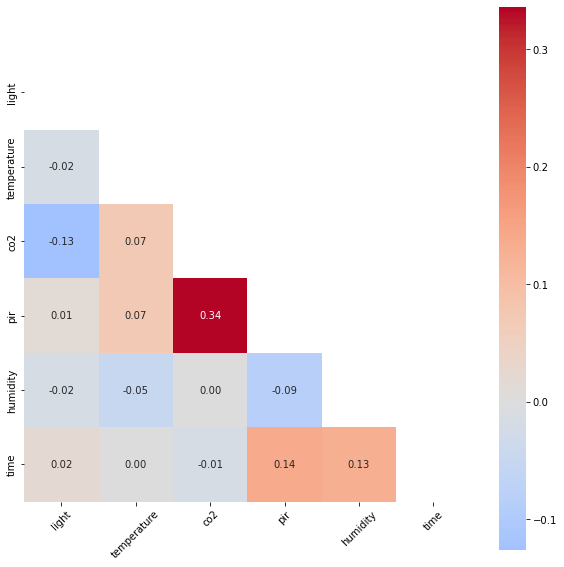

In [143]:
def dataCorr(data):
    data_corr = data.corr()
    mask = np.zeros_like(data_corr)
    mask[np.triu_indices_from(mask)] = True
    plt.subplots(figsize=(10, 10))
    dataplot = sns.heatmap(data_corr, annot=True, cmap="coolwarm", mask=mask, center=0, square=True, fmt=".2f")
    plt.xticks(rotation = 45)
    plt.show()
    
dataCorr(data)

In [144]:
data.index.duplicated()
data.reset_index(drop=True, inplace=True)

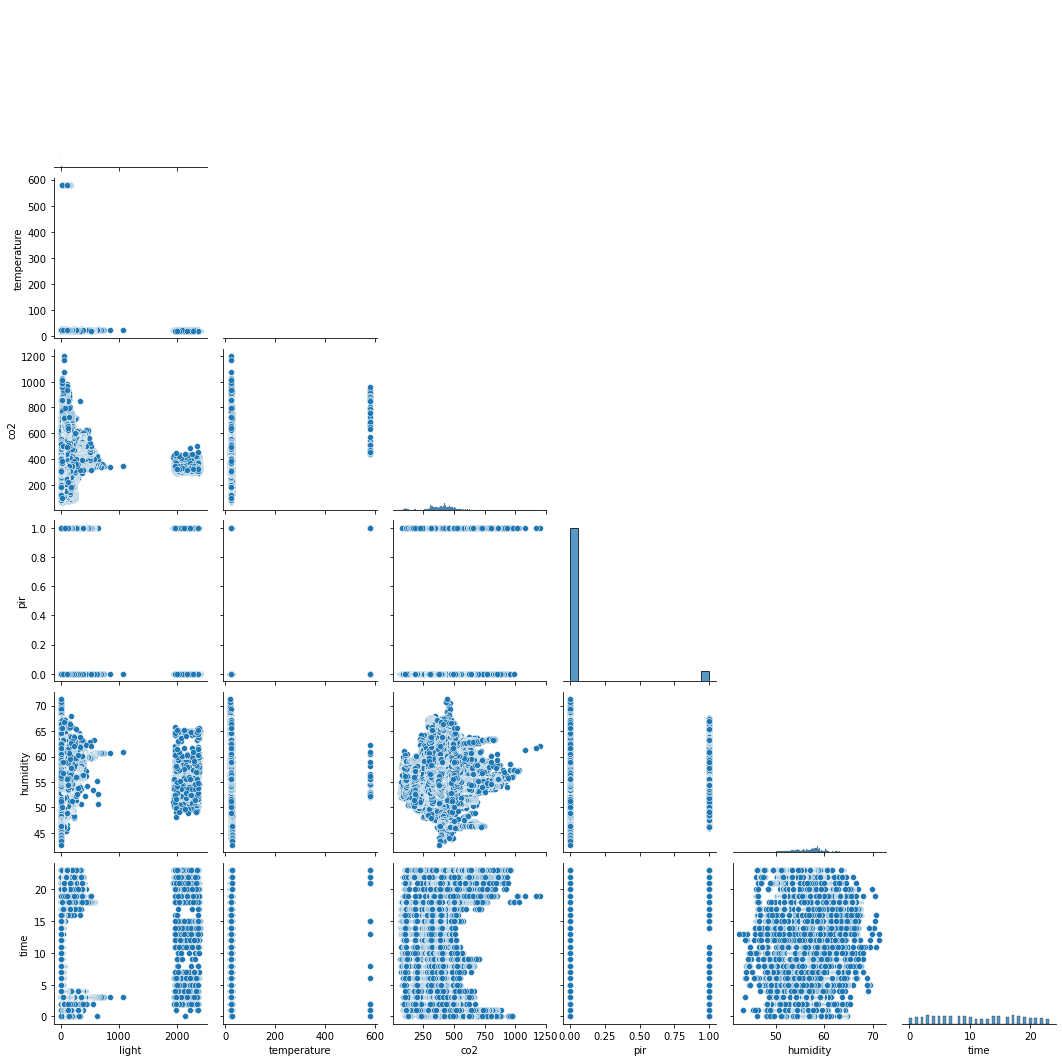

In [146]:
sns.pairplot(data, corner=True)

<AxesSubplot:xlabel='time', ylabel='pir'>

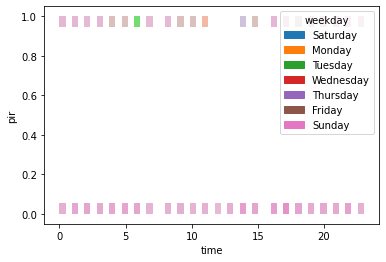

In [147]:
sns.histplot(x=data["time"], y=data["pir"], hue=data["weekday"])

In [148]:
data["temperature"].mean()

23.3792240102298

In [149]:
# sns.histplot(data["temperature"])
data["temperature"].describe()

count    128262.000000
mean         23.379224
std          11.014160
min          20.200000
25%          22.610000
50%          23.110000
75%          23.650000
max         579.270000
Name: temperature, dtype: float64

In [150]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data["weekday"] = le.fit_transform(data["weekday"])

In [151]:
data["weekday"].describe()

count    128262.000000
mean          2.682922
std           1.880560
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           6.000000
Name: weekday, dtype: float64

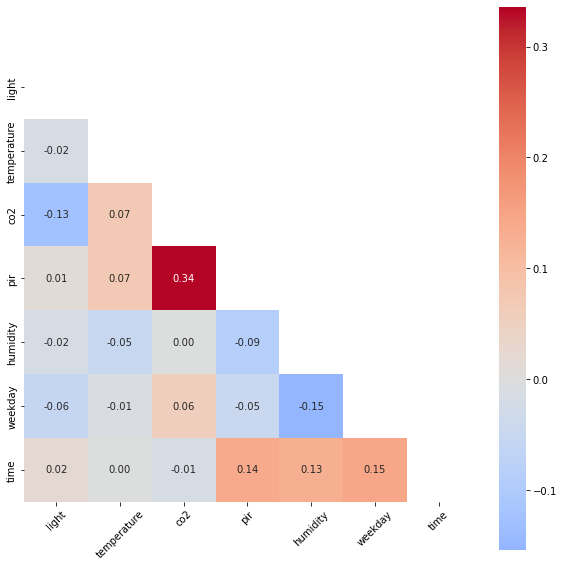

In [152]:
dataCorr(data)

In [145]:
# data.to_csv("smart_building_cleaned.csv", index=False)

In [153]:
new_data = pd.read_csv("smart_building_cleaned.csv", sep=",")

new_data.head()

,light,temperature,co2,pir,humidity,room,weekday,time
0,97.0,23.94,495.0,0,45.34,413,2,1
1,6.0,25.18,476.0,0,47.90,413,1,5
2,5.0,25.00,463.0,0,47.93,413,1,6
3,4.0,24.85,448.0,0,48.16,413,1,6
4,5.0,24.59,456.0,0,48.32,413,1,7


## Modeling

In [154]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, fbeta_score, f1_score, classification_report

In [155]:
X = new_data.drop(columns=["pir", "room"], axis=1)
y = new_data["pir"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

In [156]:
def calculate_metrics(clf, parameters, name="this model"):
    scorer = {"Accuracy": make_scorer(accuracy_score),
              "Precision":make_scorer(precision_score),
              "Recall": make_scorer(recall_score),
              "F1 Score": make_scorer(f1_score)
              }
    grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer, return_train_score=True, refit="F1 Score")
    
    grid_fit = grid_obj.fit(X_train, y_train)
    results = grid_obj.cv_results_
    best_clf = grid_fit.best_estimator_
    
    print(f"best attributes for {name} is: {best_clf}")
    print(f"results are: {pd.DataFrame(results)}")

In [157]:
def metrics(name, ypred):
    class_report = classification_report(y_test, ypred)
    
    # Displaying Classification Score
    print(f"\nThe Classification Score is:\n{class_report}")
    
    acc = round(accuracy_score(y_test, ypred), 2)
    prec = round(precision_score(y_test, ypred), 1)
    recall = round(recall_score(y_test, ypred), 2)
    f1 = round(f1_score(y_test, ypred), 2)
    f05 = round(fbeta_score(y_test, ypred, beta=0.5), 2)

    print(f"These are the results for {name}")
    print(f"Accuracy: {acc}\nPrecision: {prec}\nRecall: {recall}\nF1 Score: {f1}\nF0.5 Score: {f05}")
    return acc, prec, recall, 

### AdaBoost Classifier

In [158]:
ada = AdaBoostClassifier(random_state=40)
ada_parameters = {"base_estimator":[RandomForestClassifier()],
              "n_estimators": [10, 20],
              "learning_rate": [0.01, 0.05]}




In [159]:
calculate_metrics(ada, ada_parameters, name="AdaBoost")

best attributes for AdaBoost is: AdaBoostClassifier(base_estimator=RandomForestClassifier(), learning_rate=0.05,
                   n_estimators=20, random_state=40)
results are:    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      58.626144      2.352402         2.064971        0.146359   
1     116.116850      2.356642         4.855105        0.155849   
2      56.871098      0.318565         2.250067        0.096142   
3     129.732440      0.635913         4.895898        0.099665   

       param_base_estimator param_learning_rate param_n_estimators  \
0  RandomForestClassifier()                0.01                 10   
1  RandomForestClassifier()                0.01                 20   
2  RandomForestClassifier()                0.05                 10   
3  RandomForestClassifier()                0.05                 20   

                                              params  split0_test_Accuracy  \
0  {'base_estimator': RandomForestClassifier(), '...    

In [160]:
ada_model = AdaBoostClassifier(base_estimator=RandomForestClassifier(), n_estimators=10, learning_rate=0.01, random_state=40)
ada_model.fit(X_test, y_test)
ada_pred = ada_model.predict(X_test)

metrics("Adaboost", ada_pred)


The Classification Score is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35944
           1       1.00      1.00      1.00      2535

    accuracy                           1.00     38479
   macro avg       1.00      1.00      1.00     38479
weighted avg       1.00      1.00      1.00     38479

These are the results for Adaboost
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
F0.5 Score: 1.0


(1.0, 1.0, 1.0)

In [165]:
z=ada_model.predict([[52.0,23.4,590.0,55.01,1,21]])
print(f"the pred is {z}")

the pred is [1]


d:\Anaconda\Installation\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [ ]:
#saving model
filename = 'trained_adaboost_model.pkl'
pickle.dump(ada_model, open(filename, 'wb'))